<a href="https://colab.research.google.com/github/5213478/123/blob/main/%E5%8F%8C%E8%BE%93%E5%85%A5RESNET%2BCLDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip uninstall tensorflow
!pip install tensorflow-gpu==1.15.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip uninstall h5py
!pip install h5py==2.10.0

Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/h5py-3.1.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libaec-9c9e97eb.so.0.0.10
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libhdf5-00e8fae8.so.200.0.0
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libhdf5_hl-383c339f.so.200.0.0
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libsz-e7aa62f5.so.2.0.1
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libz-eb09ad1d.so.1.2.3
    /usr/local/lib/python3.7/dist-packages/h5py/*
Proceed (y/n)? y
  Successfully uninstalled h5py-3.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 16.2 MB/s 


In [ ]:
!pip uninstall keras
!pip install keras==2.3.1

Found existing installation: keras 2.8.0
Uninstalling keras-2.8.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/keras-2.8.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/keras/*
Proceed (y/n)? y
  Successfully uninstalled keras-2.8.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 377 kB 12.1 MB/s 


In [ ]:
import h5py
print(h5py.__version__)

2.10.0


In [ ]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")
root_path = "/content/gdrive/My Drive/"

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
#%reset
#%tensorflow_version 1.x
import joblib
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, BatchNormalization, LSTM, Conv1D, MaxPooling1D, Conv2D, Input, Concatenate, Add, PReLU
from keras.layers.convolutional import Convolution1D ,Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.initializers import glorot_uniform, Constant
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from scipy.interpolate import UnivariateSpline
from keras.utils import to_categorical
from sklearn import preprocessing
from keras.optimizers import Adam
from keras import regularizers


plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Using TensorFlow backend.


In [ ]:
EPOCHS = 100
NUM_CLASSES = 8
BATCH_SIZE = 1024 #time-series
PATIENCE = 10

In [ ]:
#Normalisation is very important
def iq2ampphase(inphase, quad):
    amplitude = np.sqrt(np.square(inphase) + np.square(quad))
    amp_norm = np.linalg.norm(amplitude) #L2 norm
    amplitude = amplitude/amp_norm #normalise
    phase = np.arctan(np.divide(quad, inphase))
    phase = 2.*(phase - np.min(phase))/np.ptp(phase)-1 #rescale phase to range [-1, 1]
    return amplitude, phase

#convert array of multiple iq samples into array of multiple ampphase samples
#ip--ap
def arr_iq2ap(X):
  X_ap = []
  for k in range(X.shape[0]):
    I = X[k][0,:]
    Q = X[k][1,:]
    amp, phase = iq2ampphase(I, Q)
    ap = np.array([amp, phase])#建立数组
    X_ap.append(ap)
  X_ap = np.array(X_ap)
  return X_ap

In [ ]:
#设置混淆矩阵
def generate_confusion_matrix(model, X,y, one_hot_transformer, batch_size):
    """
      y is the one hot encoded label vector passed to the model.evaluate
    """
    #调制--索引
    mod_to_idx = {mod:idx for idx,mod in enumerate(one_hot_transformer.classes_)} # use this to map modulation name to index
    y_hat = model.predict(X, batch_size) #输入测试数据X,输出预测结果y_hat
    y_hat_onehot = np.zeros_like(y_hat) #其维度与矩阵y_hat一致，并为其初始化为全0
    y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
    y_hat_mod = one_hot_transformer.inverse_transform(y_hat_onehot) # transform predictions to strings
    y_mod = one_hot_transformer.inverse_transform(y) # transform ground truth back to strings
    confusion_mat = np.zeros([NUM_CLASSES,NUM_CLASSES])

    acc = np.mean(y_mod == y_hat_mod)
    # fill in the confusion matrix
    for i in range(y.shape[0]):
        
        true_idx = mod_to_idx[y_mod[i]]
        pred_idx = mod_to_idx[y_hat_mod[i]]          
        confusion_mat[pred_idx,true_idx] += 1

    # normalize the matrix column wise
    for i in range(NUM_CLASSES):
        if np.sum(confusion_mat[:,i]) > 0:
          confusion_mat[:,i] /= np.sum(confusion_mat[:,i])
    
    return confusion_mat,acc

 
import seaborn as sns
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax, cmap=cmap); #annot=True to annotate cells
  
  plt.title(title)
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=45)
  plt.yticks(tick_marks, labels)
  plt.tight_layout()
  plt.ylabel('Predicted label')
  plt.xlabel('True label')

In [ ]:
#created my own LabelBinarizer class so can encode both 2-class and multiclass cases
#建立分类函数
class MyLabelBinarizer(preprocessing.LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y

    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [ ]:
class ModelEvaluater:
  def __init__(self, model, X_train, y_train, X_val, y_val, X_test, y_test,
               labels_test, batch_size, model_name, channels_first=True, feature_type=1):
    # 如果通道在前，输入的类型不变
    if channels_first:
      self.X_train = X_train
      self.X_val = X_val
      self.X_test = X_test
    else:
      self.X_train = X_train.reshape([X_train.shape[0], X_train.shape[2], X_train.shape[1]])
      self.X_val = X_val.reshape([X_val.shape[0], X_val.shape[2], X_val.shape[1]])
      self.X_test = X_test.reshape([X_test.shape[0], X_test.shape[2], X_test.shape[1]])
    
    self.feature_type = feature_type
      
    self.model = model
    self.y_train = y_train
    self.y_val = y_val
    self.y_test = y_test
    self.labels_test = labels_test
    self.model_name = model_name
    self._checkpoint_callback = ModelCheckpoint(filepath=root_path + 'model evaluation/%s-weights-{epoch}.hdf5' % self.model_name,
                                                verbose=1, save_best_only=True)
    self._train_accs = []
    self._val_accs = []
    self._snr_accs = []
    
    self.batch_size = batch_size
    
    # get the modulation types into an array
    self.mod_types = np.unique(labels_test[:,0])
  
    # fit a label binarizer 
    self.mod_to_onehot = MyLabelBinarizer()
    self.mod_to_onehot.fit(self.mod_types)

    # transform the y values to one-hot encoding
    self.y_train = self.mod_to_onehot.transform(y_train)
    self.y_val = self.mod_to_onehot.transform(y_val)
    self.y_test = self.mod_to_onehot.transform(y_test)
  
    print('y_train %s' %(y_train.shape))
    print('y_val %s' %(y_val.shape))
    print('y_test %s' %(y_test.shape))
    

    
  def fit(self, epochs, patience=10):
    curr_X, curr_y = self.X_train, self.y_train
    val_X, val_y = self.X_val, self.y_val
    callbacks = [self._checkpoint_callback, EarlyStopping(patience=patience)]
   
     # train the model
    model_info = self.model.fit(curr_X, curr_y,
                                batch_size=self.batch_size,
                                epochs=epochs,
                                verbose=1,
                                validation_data=(val_X, val_y),
                                callbacks=callbacks)

    self._train_accs.extend(model_info.history['accuracy'])
    self._val_accs.extend(model_info.history['val_accuracy'])



  def print_summary(self):
    # plot validation accuracy vs training accuracy
    plt.plot(np.arange(len(self._train_accs)), self._train_accs, '-o', label='training accuracy')
    plt.plot(np.arange(len(self._val_accs)), self._val_accs, '-o', label='validation accuracy')
    plt.legend()
    plt.xlabel('epochs')
    plt.title('%s -validation vs training accuracy' %(self.model_name))
    display(plt.show())

    #plot confusion matrix for all, low, med and high SNR
    # 有出处
    snr_ranges = [(-20, 20), (-10, 5), (6, 20)]
    for snr_rng in snr_ranges:
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where((labels_test >= snr_rng[0]) & (labels_test <=snr_rng[1]))
      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]
      conf_mat, acc = generate_confusion_matrix(self.model, X_snr, y_snr, self.mod_to_onehot, self.batch_size)
      plot_confusion_matrix(conf_mat, labels=self.mod_to_onehot.classes_, 
                            title='%s- Confusion Matrix (SNR in range %s) - acc=%s' %(self.model_name, snr_rng, acc*100))
      plt.show()

    # get accuracy per snr
    snr_accs = {}
    # unique函数去除其中重复的元素，并按元素由大到小返回一个新的无元素重复的元组或者列表
    snrs = np.unique(np.unique(self.labels_test,axis=0)[:,1]).astype('int32')
    for snr in sorted(snrs):
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where(labels_test == snr)

      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]

      y_snr = self.y_test[idx]

      #calculate acc for each snr
      mod_to_idx = {mod:idx for idx,mod in enumerate(self.mod_to_onehot.classes_)} # use this to map modulation name to index
      y_hat = self.model.predict(X_snr, self.batch_size)
      y_hat_onehot = np.zeros_like(y_hat)
      y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
      y_hat_mod = self.mod_to_onehot.inverse_transform(y_hat_onehot) # transform predictions to strings
      y_mod = self.mod_to_onehot.inverse_transform(y_snr) # transform ground truth back to strings

      acc = np.mean(y_mod == y_hat_mod)
      snr_accs[snr] = acc

    # plot the accuracy against the snr
    plt.plot(list(snr_accs.keys()),list(snr_accs.values()))
    plt.xlabel("Signal to Noise Ratio")
    plt.ylabel("Classification Accuracy")
    plt.xticks(list(snr_accs.keys()))
    plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.grid(True)
    plt.show()

    # acc--snr曲线图函数
  def accpersnr_model(self):
    snr_accs = {}
    snrs = np.unique(np.unique(self.labels_test,axis=0)[:,1]).astype('int32')
    for snr in sorted(snrs):
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where(labels_test == snr)

      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]

      #calculate acc for each snr
      mod_to_idx = {mod:idx for idx,mod in enumerate(self.mod_to_onehot.classes_)} # use this to map modulation name to index
      y_hat = self.model.predict(X_snr, self.batch_size)
      y_hat_onehot = np.zeros_like(y_hat)
      y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
      y_hat_mod = self.mod_to_onehot.inverse_transform(y_hat_onehot) # transform predictions to strings
      y_mod = self.mod_to_onehot.inverse_transform(y_snr) # transform ground truth back to strings

      acc = np.mean(y_mod == y_hat_mod)
      snr_accs[snr] = acc

    return snr_accs

    # 
  def confmat_snr(self, snr_rng):
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where((labels_test >= snr_rng[0]) & (labels_test <=snr_rng[1]))
      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]
      conf_mat, acc = generate_confusion_matrix(self.model, X_snr, y_snr, self.mod_to_onehot, self.batch_size)
      plot_confusion_matrix(conf_mat, labels=self.mod_to_onehot.classes_, 
                            title='%s- Confusion Matrix (SNR in range %s) - acc=%s' %(self.model_name, snr_rng, acc*100))
      plt.show()

In [ ]:
import joblib
data = joblib.load(root_path + 'model evaluation/data/rml_trainvaltest.hdf5')

In [ ]:
#quick understanding of data
print(data.keys())
print('Train val test size: ', data['train']['X'].shape, data['val']['X'].shape, data['test']['X'].shape)
print('Check if data is shuffled: ', data['val']['labels'][:10])

uniq, counts = np.unique(data['train']['labels'][:,1], return_counts = True)
print('Check snr range: ', uniq)
print('Check distribution of samples across SNR: ', counts)

uniq, counts = np.unique(data['train']['labels'][:,0], return_counts = True)
print('Check modulation types: ', uniq)
print('Check distribution of samples across modulation types: ', counts)

dict_keys(['train', 'val', 'test'])
Train val test size:  (107200, 2, 128) (20800, 2, 128) (32000, 2, 128)
Check if data is shuffled:  [['dBPSK' '-20']
 ['a64QAM' '-4']
 ['cCPFSK' '8']
 ['bQPSK' '-8']
 ['d4PAM' '-16']
 ['cCPFSK' '12']
 ['d4PAM' '-4']
 ['a16QAM' '0']
 ['a64QAM' '0']
 ['a64QAM' '-8']]
Check snr range:  ['-10' '-12' '-14' '-16' '-18' '-2' '-20' '-4' '-6' '-8' '0' '10' '12'
 '14' '16' '18' '2' '4' '6' '8']
Check distribution of samples across SNR:  [5392 5284 5482 5363 5291 5334 5361 5429 5328 5372 5345 5305 5362 5316
 5324 5408 5374 5401 5396 5333]
Check modulation types:  ['a16QAM' 'a64QAM' 'b8PSK' 'bQPSK' 'cCPFSK' 'cGFSK' 'd4PAM' 'dBPSK']
Check distribution of samples across modulation types:  [13521 13310 13361 13478 13329 13451 13283 13467]


In [ ]:
#load data
X_train = data['train']['X']
labels_train = data['train']['labels'] 
y_train = labels_train[:,0]

X_val = data['val']['X']
labels_val = data['val']['labels'] 
y_val = labels_val[:,0]

X_test = data['test']['X']
labels_test = data['test']['labels'] 
y_test = labels_test[:,0]

In [ ]:
#convert to ampphase
X_ap_train = arr_iq2ap(X_train)
X_ap_val = arr_iq2ap(X_val)
X_ap_test = arr_iq2ap(X_test)

In [ ]:
def build_cldnn_net(X1, X2):
  dr = 0.5  # dropout rate l

  # Reshape [N,2,128] to [N,1,2,128] on input
  input_x = Input(shape=(1, X1, X2))

  # channels_first corresponds to inputs with shape (batch, channels, height, width).
  # Build our model
  # 1*8--1*8--1*8
  input_x_padding = ZeroPadding2D((0, 2), data_format="channels_first")(input_x)

  layer1 = Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv1", init='glorot_uniform', data_format="channels_first")(input_x_padding)
  layer1 = Dropout(dr)(layer1)
  layer1_padding = ZeroPadding2D((0, 2), data_format="channels_first")(layer1)

  layer2 = Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", init='glorot_uniform', data_format="channels_first")(layer1_padding)
  layer2 = Dropout(dr)(layer2)
  layer2 = ZeroPadding2D((0, 2), data_format="channels_first")(layer2)

  layer3 = Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv3", init='glorot_uniform', data_format="channels_first")(layer2)
  layer3 = Dropout(dr)(layer3)
  # 第一层和第三层连接
  concat = keras.layers.concatenate([layer1, layer3])
  concat_size = list(np.shape(concat))
  input_dim = int(concat_size[-1] * concat_size[-2])
  timesteps = int(concat_size[-3])
  concat = Reshape((timesteps, input_dim))(concat)
  lstm_out = LSTM(50, input_dim=input_dim, input_length=timesteps)(concat)
  layer_dense1 = Dense(256, activation='relu', init='he_normal', name="dense1")(lstm_out)
  layer_dropout = Dropout(dr)(layer_dense1)
  layer_dense2 = Dense(NUM_CLASSES, init='he_normal', name="dense2")(layer_dropout)
  layer_softmax = Activation('softmax')(layer_dense2)

  output = Reshape([NUM_CLASSES])(layer_softmax)
  model = Model(inputs=input_x, outputs=output)

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv1", data_format="channels_first", kernel_initializer="glorot_uniform")`
  if sys.path[0] == '':
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", data_format="channels_first", kernel_initializer="glorot_uniform")`
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv3", data_format="channels_first", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: The

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 2, 128)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 1, 2, 132)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 2, 125)   450         zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 50, 2, 125)   0           conv1[0][0]                      
____________________________________________________________________________________________

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 107200 samples, validate on 20800 samples
Epoch 1/100
107200/107200 [==============================] - 15s 144us/step - loss: 2.0112 - accuracy: 0.1621 - val_loss: 1.8517 - val_accuracy: 0.2294

Epoch 00001: val_loss improved from inf to 1.85167, saving model to /content/gdrive/My Drive/model evaluation/cldnn8_snr--weights-1.hdf5
Epoch 2/100
107200/107200 [==============================] - 10s 96us/step - loss: 1.7415 - accuracy: 0.2827 - val_loss: 1.6754 - val_accuracy: 0.3116

Epoch 00002: val_loss improved from 1.85167 to 1.67544, saving model to /content/gdrive/My Drive/model evaluation/cldnn8_snr--weights-2.hdf5
Epoch 3/100
107200/107200 [==============================] - 10s 96us/step - loss: 1.5754 - accuracy: 0.3470 - val_loss: 1.5517 - val_accuracy: 0.3665

Epoch 00003: val_loss improved from 1.67544 to 1.55172, saving model to /content/gdrive/My Drive/model evaluation/cldnn8_snr--weights-3.hdf5
Epoch 4/100
107200/107200 [==============================] - 10s 96us/ste

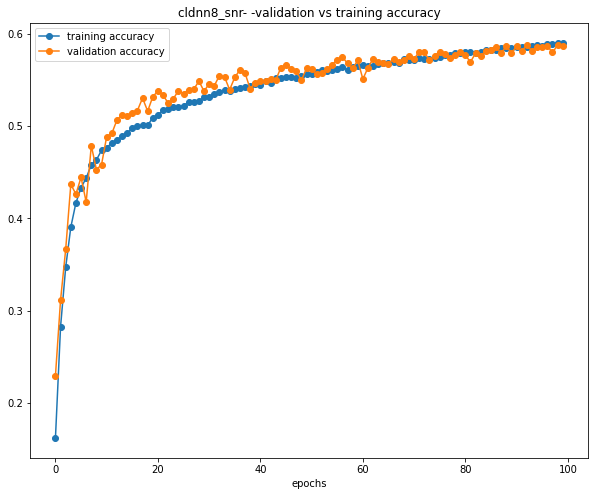

None

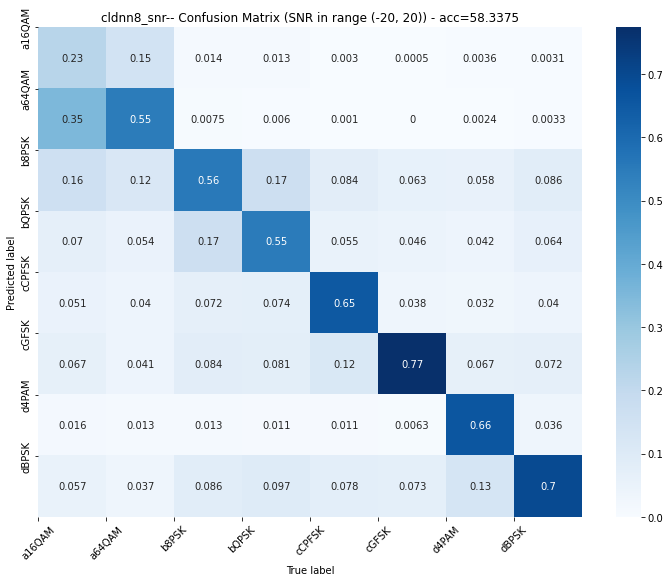

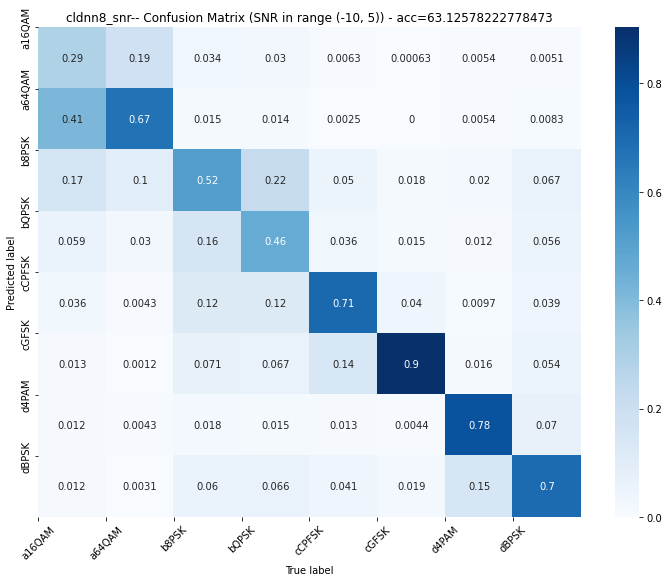

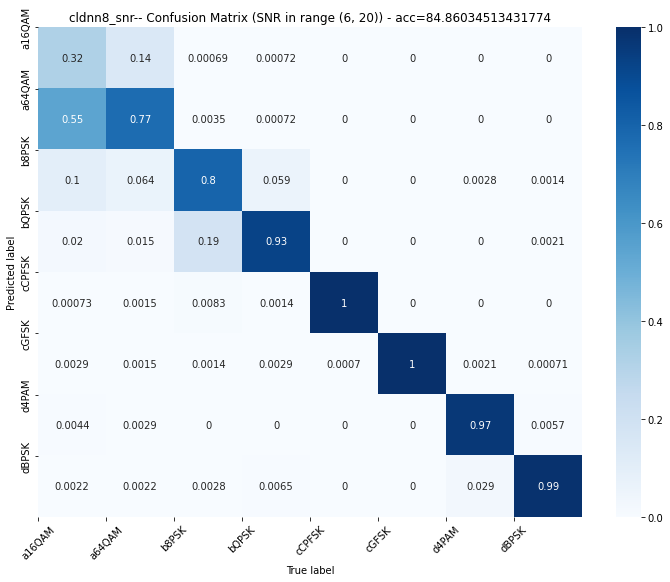

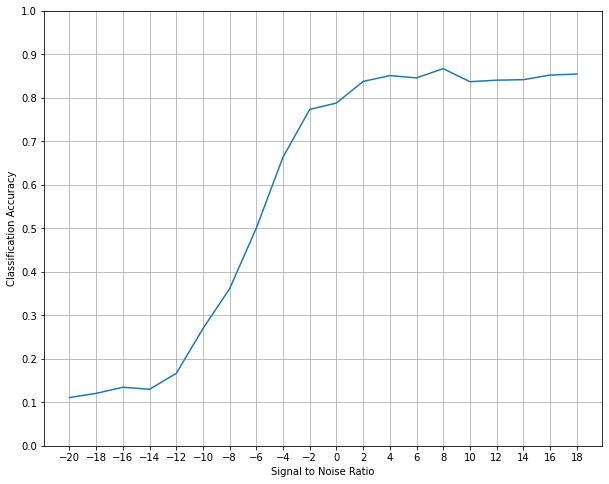

In [ ]:
#Need to reshape I/Q data from 3D into 4D to input into model
X_train2 = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])# [N, 1, 2, 128]
X_val2 = X_val.reshape(X_val.shape[0], 1, X_val.shape[1], X_val.shape[2])
X_test2 = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

cldnn_model = build_cldnn_net(X_test.shape[1], X_test.shape[2])
#cldnn_model.load_weights(root_path + 'mod_rec/cldnn8_snr--weights-75.hdf5')
cldnn_model_evaluater = ModelEvaluater(cldnn_model, X_train2, y_train,X_val2, y_val, X_test2, y_test, labels_test, BATCH_SIZE, 'cldnn8_snr-' )
cldnn_model_evaluater.fit(EPOCHS, patience=PATIENCE)
cldnn_model_evaluater.print_summary()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv1", data_format="channels_first", kernel_initializer="glorot_uniform")`
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", data_format="channels_first", kernel_initializer="glorot_uniform")`
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv3", data_format="channels_first", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1, 2, 128)    0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 1, 2, 132)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 2, 125)   450         zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 50, 2, 125)   0           conv1[0][0]                      
____________________________________________________________________________________________

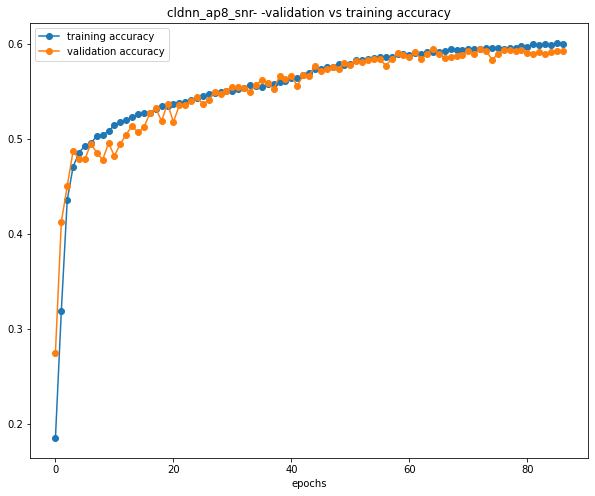

None

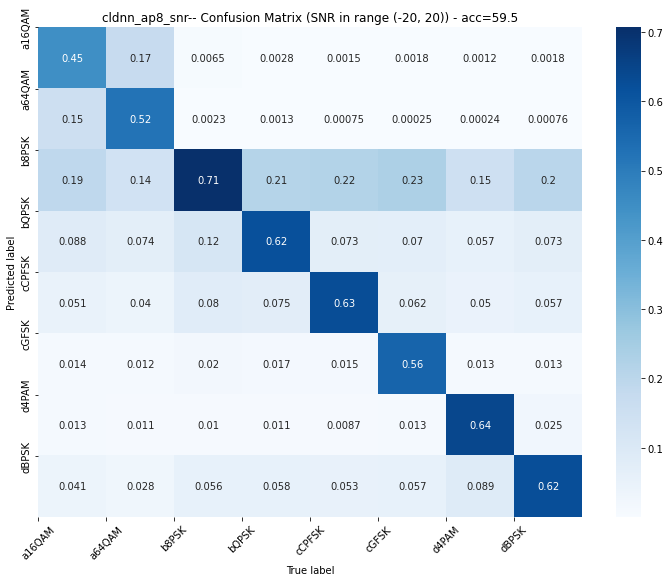

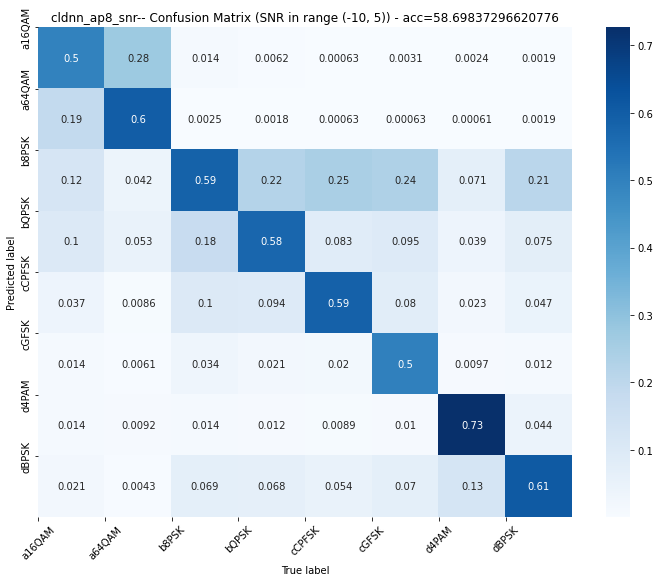

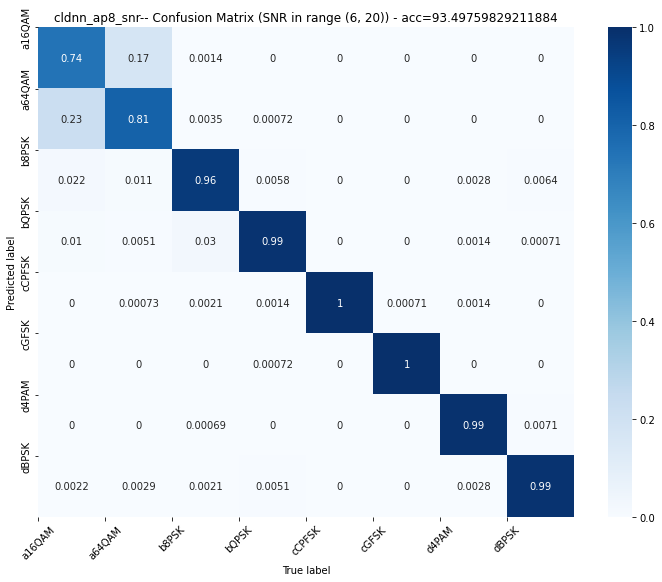

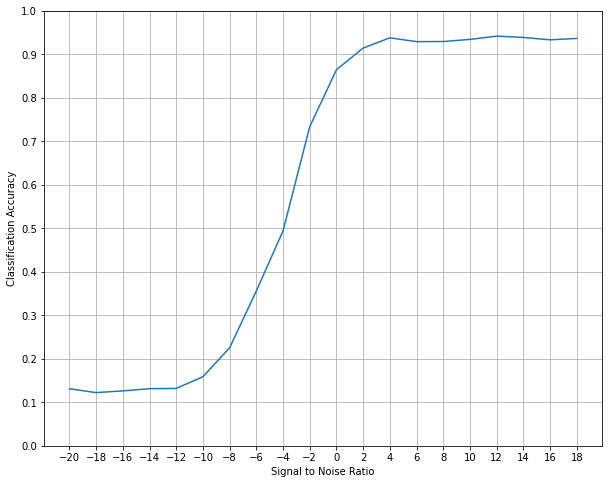

In [ ]:
#Need to reshape I/Q data from 3D into 4D to input into model
X_ap_train2 = X_ap_train.reshape(X_ap_train.shape[0], 1, X_ap_train.shape[1], X_ap_train.shape[2])
X_ap_val2 = X_ap_val.reshape(X_ap_val.shape[0], 1, X_ap_val.shape[1], X_ap_val.shape[2])
X_ap_test2 = X_ap_test.reshape(X_ap_test.shape[0], 1, X_ap_test.shape[1], X_ap_test.shape[2])

cldnn_ap_model = build_cldnn_net(X_ap_test.shape[1], X_ap_test.shape[2])
cldnn_ap_model_evaluater = ModelEvaluater(cldnn_ap_model, X_ap_train2, y_train, X_ap_val2, y_val, X_ap_test2, y_test, labels_test, BATCH_SIZE, 'cldnn_ap8_snr-' )
cldnn_ap_model_evaluater.fit(EPOCHS, patience=PATIENCE)
cldnn_ap_model_evaluater.print_summary()

In [ ]:
import joblib
data = joblib.load(root_path + 'model evaluation/data/rml_trainvaltest.hdf5')

In [ ]:
#load data
X_train = data['train']['X']
labels_train = data['train']['labels'] 

X_val = data['val']['X']
labels_val = data['val']['labels'] 

X_test = data['test']['X']
labels_test = data['test']['labels'] 

In [ ]:
#relabel QAMs and high order PSKs as 'QAMPSK'
y_train = labels_train[:,0]
y_train[(y_train == 'a16QAM') | (y_train == 'a64QAM') | (y_train == 'bQPSK') | (y_train == 'b8PSK')] = 'QAMPSK'

y_val = labels_val[:,0]
y_val[(y_val == 'a16QAM') | (y_val == 'a64QAM') | (y_val == 'bQPSK') | (y_val == 'b8PSK')] = 'QAMPSK'

y_test = labels_test[:,0]
y_test[(y_test == 'a16QAM') | (y_test == 'a64QAM') | (y_test == 'bQPSK') | (y_test == 'b8PSK')] = 'QAMPSK'

y = labels_test[:,0]
idx = np.where((y == 'a16QAM') | (y == 'a64QAM') | (y == 'bQPSK') | (y == 'b8PSK'))
labels_test[idx][:,0] = y_test[idx]

In [ ]:
#check distribution of classes
uniq_train, counts_train = np.unique(y_train, return_counts=True)
uniq_val, counts_val = np.unique(y_val, return_counts=True)
uniq_test, counts_test = np.unique(y_test, return_counts=True)
print(counts_train)
print(counts_val)
print(counts_test)

[53670 13329 13451 13283 13467]
[10384  2656  2555  2606  2599]
[15946  4015  3994  4111  3934]


In [ ]:
#only retain 0.25 of QAMPSK for training to maintain even proportion
idx = np.array(np.where(y_train == 'QAMPSK')).reshape(-1)
idx_throw = idx[:int(idx.shape[0]*0.75)]
idx_keep = [i for i in range(y_train.shape[0]) if i not in idx_throw ]
y_train = y_train[idx_keep]
X_train = X_train[idx_keep]

idx = np.array(np.where(y_val == 'QAMPSK')).reshape(-1)
idx_throw = idx[:int(idx.shape[0]*0.75)]
idx_keep = [i for i in range(y_val.shape[0]) if i not in idx_throw ]
y_val = y_val[idx_keep]
X_val = X_val[idx_keep]

idx = np.array(np.where(y_test == 'QAMPSK')).reshape(-1)
idx_throw = idx[:int(idx.shape[0]*0.75)]
idx_keep = [i for i in range(y_test.shape[0]) if i not in idx_throw ]
y_test = y_test[idx_keep]
X_test = X_test[idx_keep]
labels_test = labels_test[idx_keep]

In [ ]:
#check new distribution of classes
uniq_train, counts_train = np.unique(y_train, return_counts=True)
uniq_val, counts_val = np.unique(y_val, return_counts=True)
uniq_test, counts_test = np.unique(y_test, return_counts=True)
print(counts_train)
print(counts_val)
print(counts_test)

[13418 13329 13451 13283 13467]
[2596 2656 2555 2606 2599]
[3987 4015 3994 4111 3934]


In [ ]:
# 1d conv resnet
# 整个模型架构
def residual_stack(x, f):
    # 1x1 conv linear
    # ffilters: 整数，输出空间的维度 （即卷积中滤波器的输出数量）。
    # kernel_size: 一个整数，或者单个整数表示的元组或列表， 指明 1D 卷积窗口的长度。
    x = Conv1D(f, 1, strides=1, padding='same', data_format='channels_last')(x)
    x = Activation('linear')(x)
    
    # residual unit 1    
    x_shortcut = x
    x = Conv1D(f, 3, strides=1, padding="same", data_format='channels_last')(x)
    x = Activation('relu')(x)
    x = Conv1D(f, 3, strides=1, padding="same", data_format='channels_last')(x)
    x = Activation('linear')(x)
    # add skip connection
    # 维度相同时，拼接
    if x.shape[1:] == x_shortcut.shape[1:]:
      x = Add()([x, x_shortcut])
    else:
      raise Exception('Skip Connection Failure!')
      
    # residual unit 2    
    x_shortcut = x
    x = Conv1D(f, 3, strides=1, padding="same", data_format='channels_last')(x)
    x = Activation('relu')(x)
    x = Conv1D(f, 3, strides = 1, padding = "same", data_format='channels_last')(x)
    x = Activation('linear')(x)
    # add skip connection
    if x.shape[1:] == x_shortcut.shape[1:]:
      x = Add()([x, x_shortcut])
    else:
      raise Exception('Skip Connection Failure!')
      
    # max pooling layer
    x = MaxPooling1D(pool_size=2, strides=None, padding='valid', data_format='channels_last')(x)
    return x

# define resnet model
# 定义残差块
def build_ResNet(input_shape, classes):   
    # create input tensor
    x_input = Input(input_shape)
    x = x_input
    # residual stack
    num_filters = 40
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    
    # output layer
    x = Flatten()(x)
    x = Dense(128, activation="selu", kernel_initializer="he_normal")(x)
    x = Dropout(.5)(x)
    x = Dense(128, activation="selu", kernel_initializer="he_normal")(x)
    x = Dropout(.5)(x)
    x = Dense(classes , activation='softmax', kernel_initializer = glorot_uniform(seed=0))(x)
    
    # Create model
    model = Model(inputs = x_input, outputs = x)

    adm = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0, amsgrad=False)
    model.compile(optimizer=adm, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 2)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 128, 40)      120         input_3[0][0]                    
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 128, 40)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 128, 40)      4840        activation_3[0][0]               
____________________________________________________________________________________________

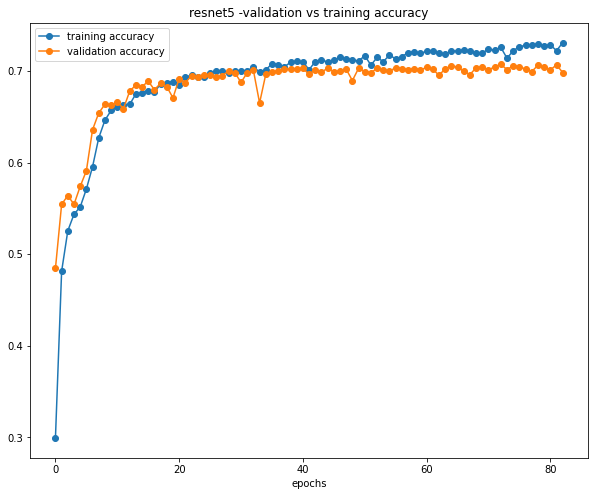

None

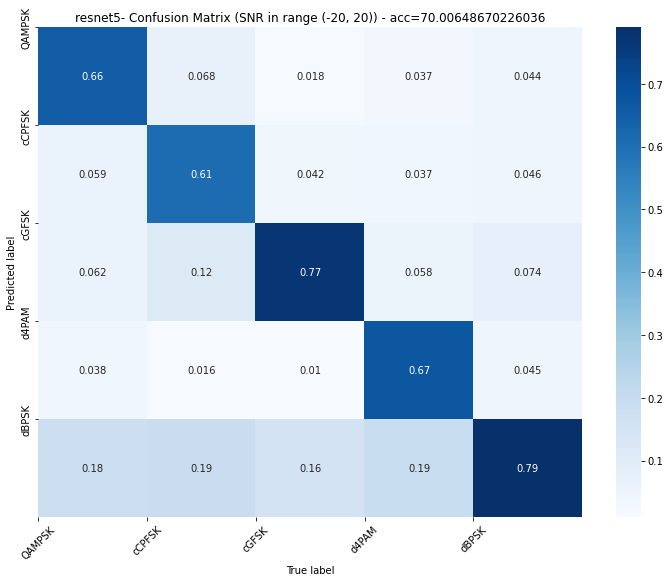

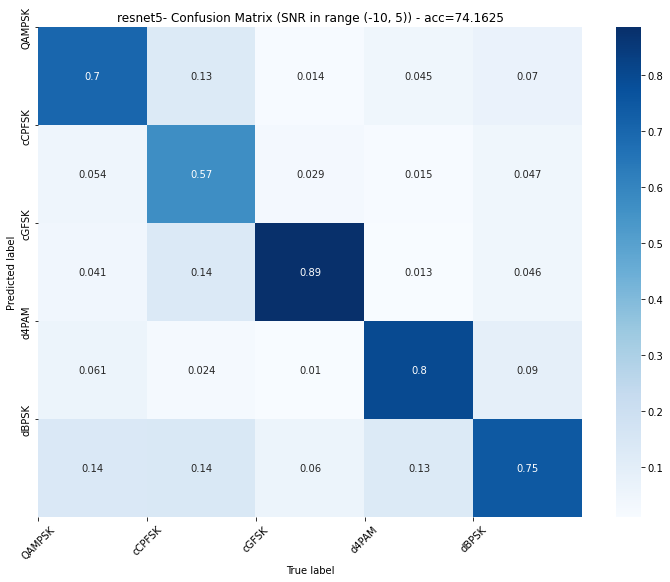

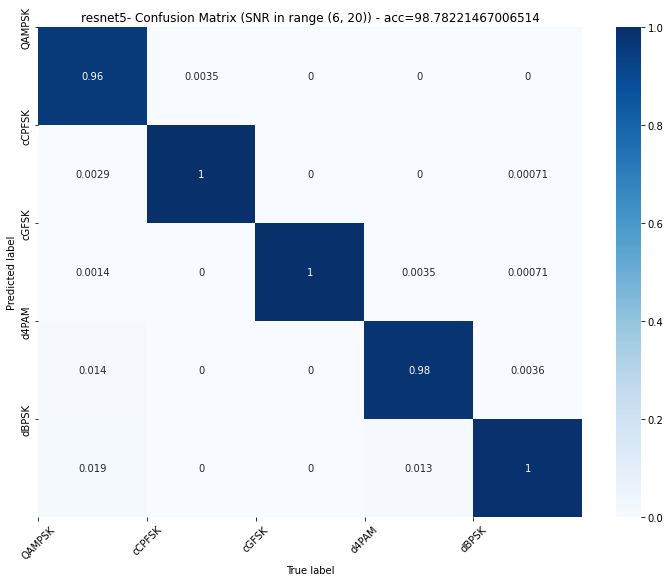

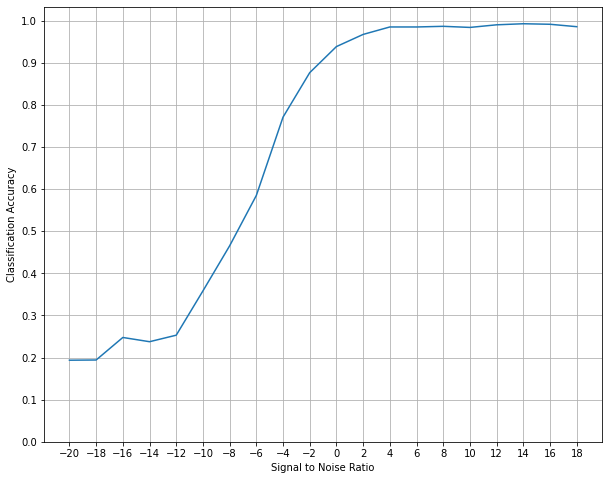

In [ ]:
NUM_CLASSES = 5 # 最终分类数为5
resnet_model = build_ResNet((X_test.shape[2],X_test.shape[1]), NUM_CLASSES)
resnet_model_evaluater = ModelEvaluater(resnet_model, X_train, y_train, X_val, y_val, X_test, y_test, labels_test, BATCH_SIZE, 'resnet5', channels_first=False)
resnet_model_evaluater.fit(EPOCHS, patience=PATIENCE)
resnet_model_evaluater.print_summary()

In [ ]:
import joblib
data = joblib.load(root_path + 'model evaluation/data/rml_trainvaltest.hdf5')

In [ ]:
#load data
X_train = data['train']['X']
labels_train = data['train']['labels'] 

X_val = data['val']['X']
labels_val = data['val']['labels'] 

X_test = data['test']['X']
labels_test = data['test']['labels'] 

In [ ]:
#Extract QAMs and PSKs only
y = labels_train[:,0]
idx = np.where((y == 'a16QAM') | (y == 'a64QAM') | (y == 'bQPSK') | (y == 'b8PSK'))
y_train = y[idx]
X_train = X_train[idx]

y = labels_val[:,0]
idx = np.where((y == 'a16QAM') | (y == 'a64QAM') | (y == 'bQPSK') | (y == 'b8PSK'))
y_val = y[idx]
X_val = X_val[idx]

y = labels_test[:,0]
idx = np.where((y == 'a16QAM') | (y == 'a64QAM') | (y == 'bQPSK') | (y == 'b8PSK'))
y_test = y[idx]
X_test = X_test[idx]
labels_test = labels_test[idx]

In [ ]:
#convert to ampphase
X_ap_train = arr_iq2ap(X_train)
X_ap_val = arr_iq2ap(X_val)
X_ap_test = arr_iq2ap(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv1", data_format="channels_first", kernel_initializer="glorot_uniform")`
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", data_format="channels_first", kernel_initializer="glorot_uniform")`
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv3", data_format="channels_first", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1, 2, 128)    0                                            
__________________________________________________________________________________________________
zero_padding2d_7 (ZeroPadding2D (None, 1, 2, 132)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 2, 125)   450         zero_padding2d_7[0][0]           
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 50, 2, 125)   0           conv1[0][0]                      
____________________________________________________________________________________________

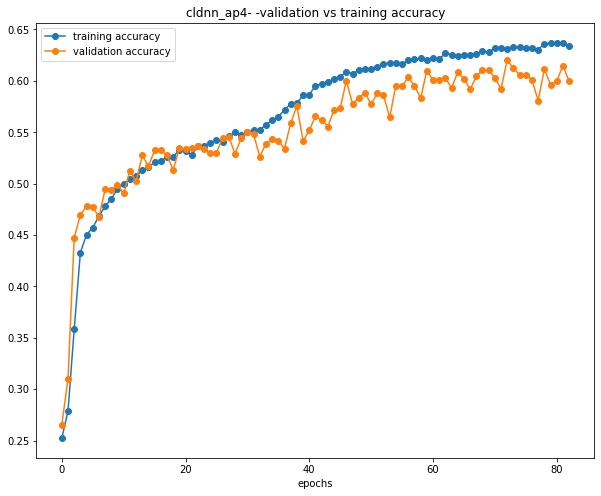

None

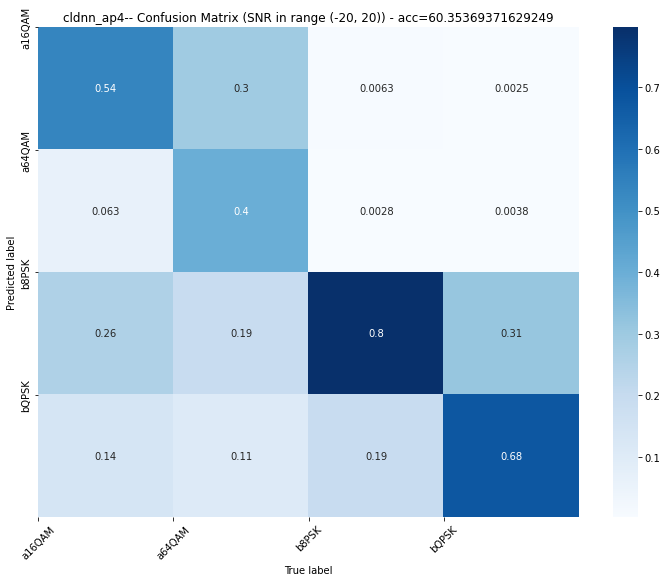

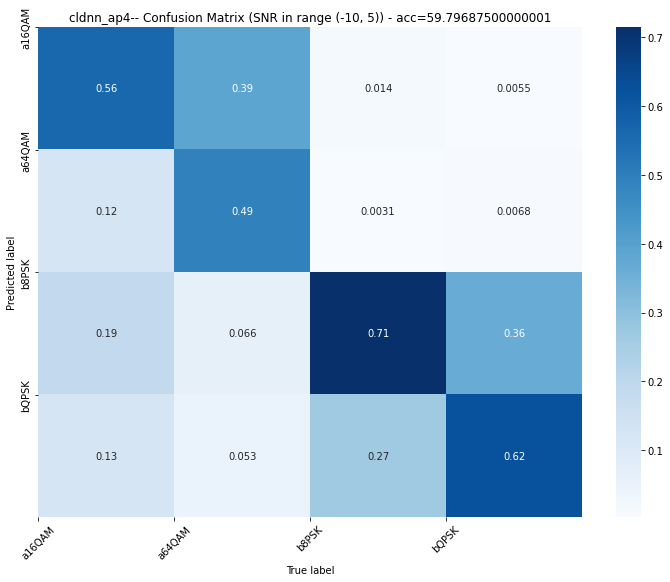

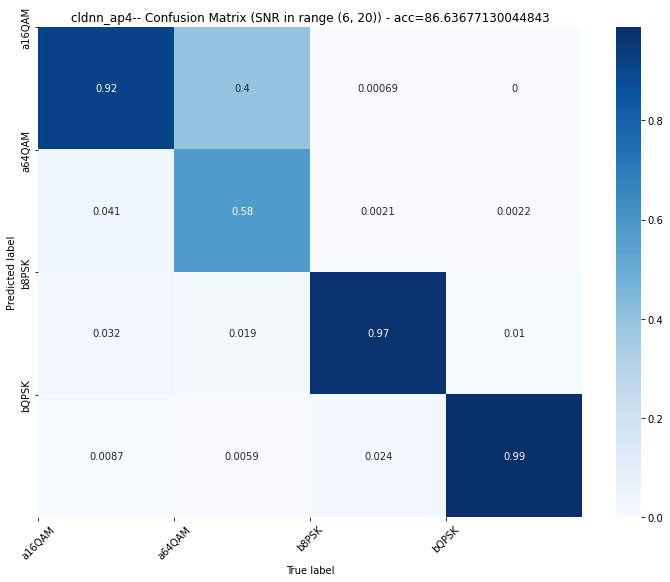

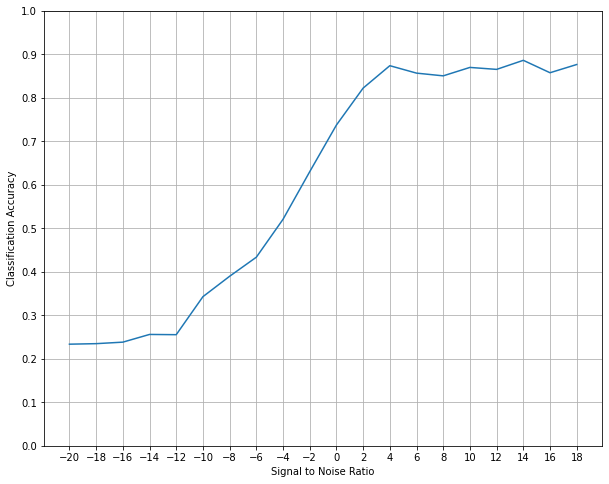

In [ ]:
NUM_CLASSES = 4
#Need to reshape I/Q data from 3D into 4D to input into model
X_ap_train2 = X_ap_train.reshape(X_ap_train.shape[0], 1, X_ap_train.shape[1], X_ap_train.shape[2])
X_ap_val2 = X_ap_val.reshape(X_ap_val.shape[0], 1, X_ap_val.shape[1], X_ap_val.shape[2])
X_ap_test2 = X_ap_test.reshape(X_ap_test.shape[0], 1, X_ap_test.shape[1], X_ap_test.shape[2])

cldnn_ap_model = build_cldnn_net(X_ap_test.shape[1], X_ap_test.shape[2])
cldnn_ap_model_evaluater = ModelEvaluater(cldnn_ap_model, X_ap_train2, y_train, X_ap_val2, y_val, X_ap_test2, y_test, labels_test, BATCH_SIZE, 'cldnn_ap4-' )
cldnn_ap_model_evaluater.fit(EPOCHS, patience=PATIENCE)
cldnn_ap_model_evaluater.print_summary()

In [ ]:
#After a bit of guessing and validation
#Probs can use onehot also...
cnn1_classdict = {}
cnn1_classdict[0] = 'QAMPSK'
cnn1_classdict[1] = 'cCPFSK'
cnn1_classdict[2] = 'cGFSK'
cnn1_classdict[3] = 'd4PAM'
cnn1_classdict[4] = 'dBPSK'

cnn2_classdict = {}
cnn2_classdict[0] = 'a16QAM'
cnn2_classdict[1] = 'a64QAM'
cnn2_classdict[2] = 'b8PSK'
cnn2_classdict[3] = 'bQPSK'

mod_to_idx = {}
mod_to_idx['a16QAM'] = 0
mod_to_idx['a64QAM'] = 1
mod_to_idx['b8PSK'] = 2
mod_to_idx['bQPSK'] = 3
mod_to_idx['cCPFSK'] = 4
mod_to_idx['cGFSK'] = 5
mod_to_idx['d4PAM'] = 6
mod_to_idx['dBPSK'] = 7

In [ ]:
#combine predictions from cnn1 and cnn2
def combined_predict(X_test):
  #cnn1
  nclass = 5
  X_iq = X_test.reshape([X_test.shape[0], X_test.shape[2], X_test.shape[1]])
  cnn_1 = build_ResNet((X_iq.shape[1], X_iq.shape[2]), nclass)#1  2
  cnn_1.load_weights(root_path + 'model evaluation/resnet5-weights-73.hdf5')

  out_prob = cnn_1.predict(X_iq)
  out_pred = np.argmax(out_prob,axis=1) # 打印最大概率对应的标签
  out_pred = np.array([cnn1_classdict[i] for i in out_pred])

  idx = np.where(out_pred == 'QAMPSK') #寻找QAMPSK的坐标
  X_QAMPSK = X_test[idx]
  X_ap = arr_iq2ap(X_QAMPSK)

  #cnn2
  #NUM_CLASSES = 4
  X_ap = X_ap.reshape(X_ap.shape[0], 1, X_ap.shape[1], X_ap.shape[2])
  cnn_2 = build_cldnn_net(X_ap.shape[2], X_ap.shape[3])#2  3
  cnn_2.load_weights(root_path + 'model evaluation/cldnn_ap4--weights-73.hdf5')
  out_prob2 = cnn_2.predict(X_ap)
  out_pred2 = np.argmax(out_prob2,axis=1)
  out_pred2 = np.array([cnn2_classdict[i] for i in out_pred2])

  j = 0
  for i, out in enumerate(out_pred):
    if out=='QAMPSK':
      out_pred[i] = out_pred2[j]
      j = j+1
  
  return out_pred


#plot conf mat given predicted and true arrays
def createnplot_confmat(out_pred, y_true):
  confusion_mat = np.zeros([8,8])
  acc = np.mean(out_pred == y_true) #取平均
  # fill in the confusion matrix
  for i in range(y_true.shape[0]):
      true_idx = mod_to_idx[y_true[i]]
      pred_idx = mod_to_idx[out_pred[i]]          
      confusion_mat[pred_idx,true_idx] += 1

  # normalize the matrix column wise
  for i in range(8):
      if np.sum(confusion_mat[:,i]) > 0:
        confusion_mat[:,i] /= np.sum(confusion_mat[:,i])

  plot_confusion_matrix(confusion_mat, title=str(acc), labels = np.unique(labels_test[:,0]))


#return accuracies across snr range
def snr_accs(out_pred, labels_true):
  snr_accs = {}
  labels_snrs = np.array([int(snr) for snr in labels_true[:,1]])
  snrs_uniq = np.unique(labels_snrs)

  for snr in sorted(snrs_uniq):
    idx = np.where(labels_snrs == snr)
    y_pred = out_pred[idx]
    y_true = labels_true[idx][:,0]
    acc = np.mean(y_pred == y_true)
    snr_accs[snr] = acc
  return snr_accs

In [ ]:
import joblib
data = joblib.load(root_path + 'model evaluation/data/rml_trainvaltest.hdf5')

In [ ]:
#load data
X_train = data['train']['X']
labels_train = data['train']['labels'] 
y_train = labels_train[:,0]

X_val = data['val']['X']
labels_val = data['val']['labels'] 
y_val = labels_val[:,0]

X_test = data['test']['X']
labels_test = data['test']['labels'] 
y_test = labels_test[:,0]

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 128, 2)       0                                            
__________________________________________________________________________________________________
conv1d_26 (Conv1D)              (None, 128, 40)      120         input_5[0][0]                    
__________________________________________________________________________________________________
activation_29 (Activation)      (None, 128, 40)      0           conv1d_26[0][0]                  
__________________________________________________________________________________________________
conv1d_27 (Conv1D)              (None, 128, 40)      4840        activation_29[0][0]              
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv1", data_format="channels_first", kernel_initializer="glorot_uniform")`
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", data_format="channels_first", kernel_initializer="glorot_uniform")`
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv3", data_format="channels_first", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 1, 2, 128)    0                                            
__________________________________________________________________________________________________
zero_padding2d_10 (ZeroPadding2 (None, 1, 2, 132)    0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 2, 125)   450         zero_padding2d_10[0][0]          
__________________________________________________________________________________________________
dropout_17 (Dropout)            (None, 50, 2, 125)   0           conv1[0][0]                      
____________________________________________________________________________________________

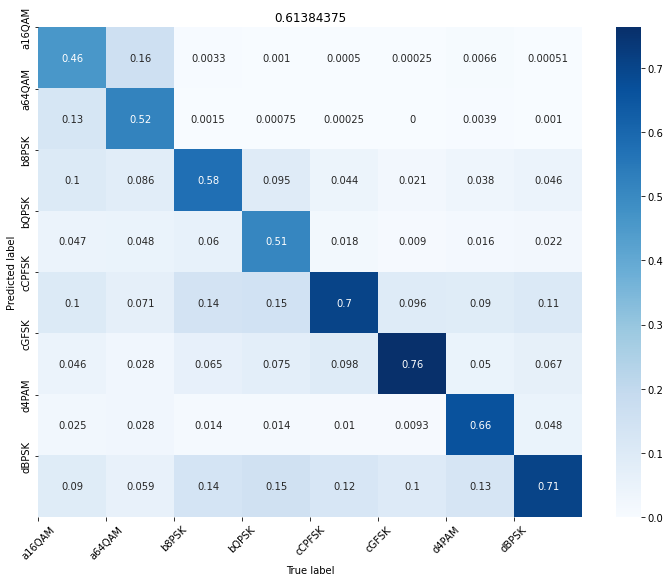

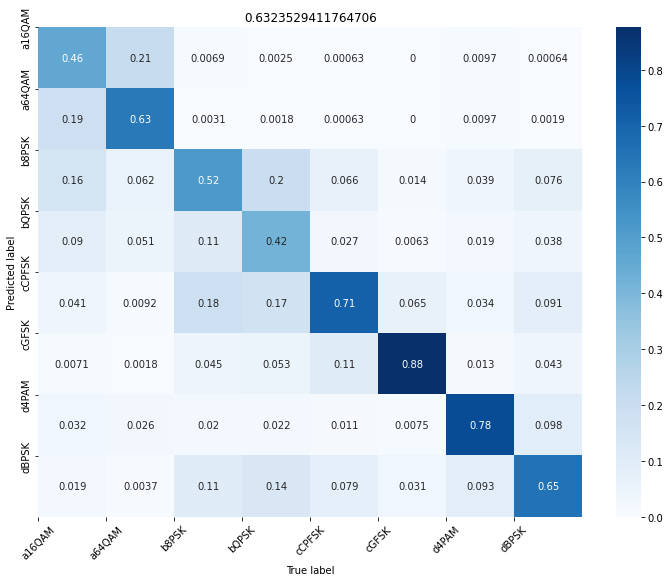

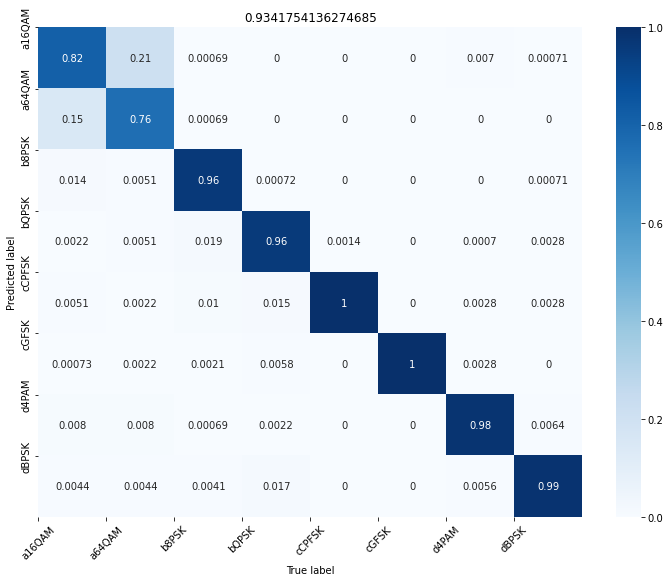

In [ ]:
#plot confusion matrices at different snr
NUM_CLASSES = 4
out_pred = combined_predict(X_test)

snr_ranges = [(-20, 20), (-10, 5), (6, 20)]
for i, snr_rng in enumerate(snr_ranges):
   snrs = np.array([int(lbl) for lbl in labels_test[:,1]])
   idx = np.where((snrs >= snr_rng[0]) & (snrs <=snr_rng[1]))

   y_pred_snr = out_pred[idx]
   y_snr = labels_test[idx][:,0]
   plt.subplot(1,3,i+1)
   createnplot_confmat(y_pred_snr, y_snr)
   plt.show()

In [ ]:
#combined predict
NUM_CLASSES = 4
out_combined = combined_predict(X_test)
combined_accpersnr = snr_accs(out_combined, labels_test)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 128, 2)       0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 128, 40)      120         input_7[0][0]                    
__________________________________________________________________________________________________
activation_55 (Activation)      (None, 128, 40)      0           conv1d_51[0][0]                  
__________________________________________________________________________________________________
conv1d_52 (Conv1D)              (None, 128, 40)      4840        activation_55[0][0]              
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv1", data_format="channels_first", kernel_initializer="glorot_uniform")`
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", data_format="channels_first", kernel_initializer="glorot_uniform")`
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv3", data_format="channels_first", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 1, 2, 128)    0                                            
__________________________________________________________________________________________________
zero_padding2d_13 (ZeroPadding2 (None, 1, 2, 132)    0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 2, 125)   450         zero_padding2d_13[0][0]          
__________________________________________________________________________________________________
dropout_23 (Dropout)            (None, 50, 2, 125)   0           conv1[0][0]                      
____________________________________________________________________________________________

In [ ]:
NUM_CLASSES = 8
#CLDNN trained on low, med, high SNRs
X_test2 = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])
cldnn_model = build_cldnn_net(X_test.shape[1], X_test.shape[2])
cldnn_model.load_weights(root_path + 'model evaluation/cldnn8_snr--weights-93.hdf5')
cldnn_model_evaluater = ModelEvaluater(cldnn_model, X_test2, y_test,X_test2, y_test, X_test2, y_test, labels_test, BATCH_SIZE, 'cldnn8-' )
cldnn_accpersnr = cldnn_model_evaluater.accpersnr_model()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv1", data_format="channels_first", kernel_initializer="glorot_uniform")`
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", data_format="channels_first", kernel_initializer="glorot_uniform")`
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv3", data_format="channels_first", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 1, 2, 128)    0                                            
__________________________________________________________________________________________________
zero_padding2d_16 (ZeroPadding2 (None, 1, 2, 132)    0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 2, 125)   450         zero_padding2d_16[0][0]          
__________________________________________________________________________________________________
dropout_27 (Dropout)            (None, 50, 2, 125)   0           conv1[0][0]                      
____________________________________________________________________________________________

In [ ]:
#convert to ampphase
X_ap_train = arr_iq2ap(X_train)
X_ap_val = arr_iq2ap(X_val)
X_ap_test = arr_iq2ap(X_test)

In [ ]:
X_ap_test2 = X_ap_test.reshape(X_ap_test.shape[0], 1, X_ap_test.shape[1], X_ap_test.shape[2])
cldnn_ap_model = build_cldnn_net(X_ap_test.shape[1], X_ap_test.shape[2])
cldnn_ap_model.load_weights(root_path + 'model evaluation/cldnn_ap8_snr--weights-77.hdf5')
cldnn_ap_model_evaluater = ModelEvaluater(cldnn_ap_model, X_ap_test2, y_test, X_ap_test2, y_test, X_ap_test2, y_test, labels_test, BATCH_SIZE, 'cldnn_ap8-' )
cldnn_ap_accpersnr = cldnn_ap_model_evaluater.accpersnr_model()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv1", data_format="channels_first", kernel_initializer="glorot_uniform")`
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv2", data_format="channels_first", kernel_initializer="glorot_uniform")`
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv3", data_format="channels_first", kernel_initializer="glorot_uniform")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 1, 2, 128)    0                                            
__________________________________________________________________________________________________
zero_padding2d_19 (ZeroPadding2 (None, 1, 2, 132)    0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 2, 125)   450         zero_padding2d_19[0][0]          
__________________________________________________________________________________________________
dropout_31 (Dropout)            (None, 50, 2, 125)   0           conv1[0][0]                      
___________________________________________________________________________________________

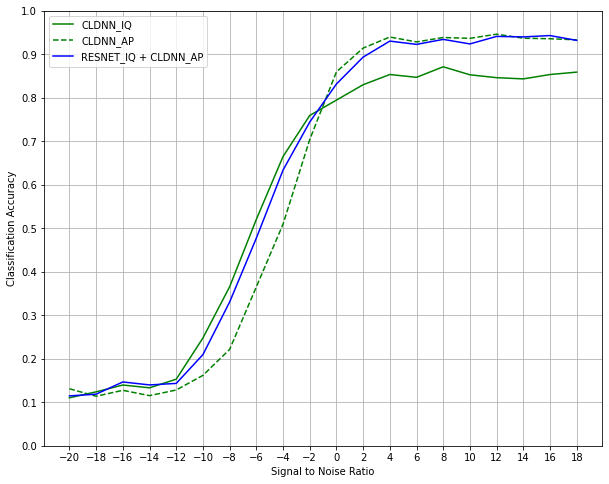

In [ ]:
# plot acc-vs-snr graphs for different models
cldnn, = plt.plot(list(cldnn_accpersnr.keys()),list(cldnn_accpersnr.values()), 'g-', label='CLDNN_IQ')
cldnn_ap, = plt.plot(list(cldnn_ap_accpersnr.keys()),list(cldnn_ap_accpersnr.values()), 'g--', label='CLDNN_AP')
combined, = plt.plot(list(combined_accpersnr.keys()),list(combined_accpersnr.values()), 'b-', label='RESNET_IQ + CLDNN_AP')

plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.xticks(list(cldnn_accpersnr.keys()))
plt.legend(handles = [cldnn, cldnn_ap, combined])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid(True)
plt.show()